In [ ]:
#!pip install scikit-learn --upgrade
#!pip install tensorflow --upgrade
#!pip install scikeras

!pip install scikit-learn==1.3.0
!pip install tensorflow==2.13.0
!pip install scikeras==0.10.1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Daily_using   366 non-null    float64
 1   Daily_growth  366 non-null    float64
 2   Daily_cost    366 non-null    float64
dtypes: float64(3)
memory usage: 11.4 KB


None

,Daily_using,Daily_growth,Daily_cost
Date,,,
2024-01-01,40.581311,40.581311,1.014533
2024-01-02,95.317859,135.899170,3.397479
2024-01-03,74.539424,210.438595,5.260965
2024-01-04,61.872556,272.311151,6.807779
2024-01-05,19.821771,292.132922,7.303323
...,...,...,...
2024-12-27,66.112381,18669.586427,466.739661
2024-12-28,48.534025,18718.120452,467.953011
2024-12-29,56.833595,18774.954046,469.373851


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.9946
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.7146
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.5522
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.4320
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.3322
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.2711
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.2245
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1867
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1454
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.1355
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.1220
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.1208
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1020
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1019
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0948
E

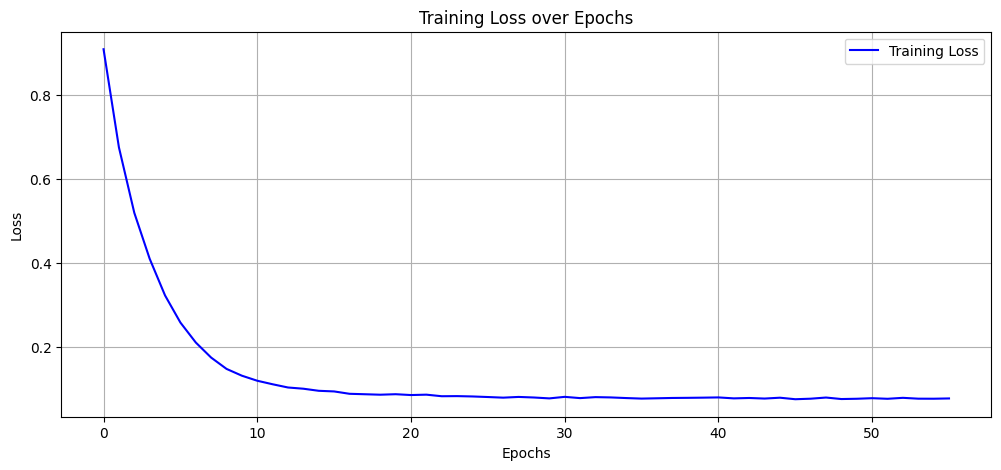

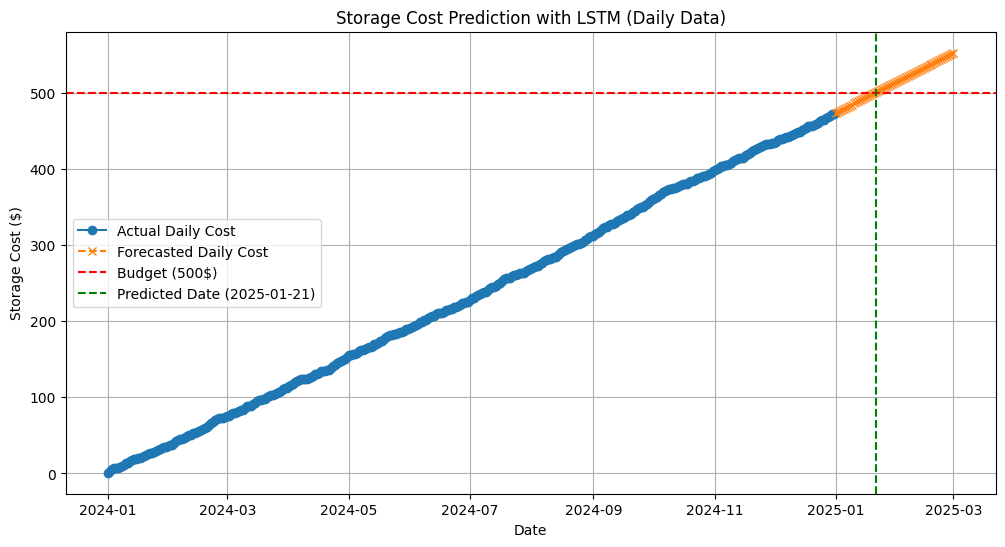

In [5]:
# 굳
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 데이터 생성 및 초기 설정
storage_cost = 0.025
budget = 500  # 목표 예산
forecast_steps = 60  # 예측할 최대 일 수

# 샘플 date
year = 2024
start_date = f"{year}-01-01"
end_date = f"{year}-12-31"
dates = pd.date_range(start=start_date, end=end_date)

# 하루당 증가 용량 (GB)
np.random.seed(42)

# 모든 값을 합쳐서 daily_using 생성
storage = pd.DataFrame({
    'Daily_using': np.random.uniform(5, 100, size=len(dates))
})

storage['Date'] = dates
storage['Daily_growth'] = storage['Daily_using'].cumsum()
storage['Daily_cost'] = storage['Daily_growth'] * storage_cost
storage.set_index('Date', inplace=True)

# 데이터 준비
data = pd.DataFrame({
    'TotalCost': storage['Daily_cost']
})

# 차분 데이터 생성
data['Diff'] = data['TotalCost'].diff().fillna(0)

display(storage.info())
display(storage)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Diff']])

# LSTM 입력 데이터 준비 함수
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# look_back 설정
look_back = 90
X, y = create_lstm_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형식

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # 출력 레이어

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, min_delta=1e-4, verbose=1)

# 모델 학습
history = model.fit(X, y, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])

# 예측 데이터 생성
X_forecast = data_scaled[-look_back:]  # 가장 최근 데이터를 가져옴
X_forecast = np.reshape(X_forecast, (1, look_back, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    next_step = model.predict(X_forecast, verbose=0)
    forecast_scaled.append(next_step[0, 0])
    X_forecast = np.append(X_forecast[:, 1:, :], next_step.reshape(1, 1, 1), axis=1)

# 차분 데이터 복원
forecast_diff = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_cumulative = [data['TotalCost'].iloc[-1]] + list(np.cumsum(forecast_diff) + data['TotalCost'].iloc[-1])

# 예산 도달 시점 계산
predicted_day = None
for i, cost in enumerate(forecast_cumulative[1:], start=1):
    if cost >= budget:
        predicted_day = i
        break

# 결과 출력
if predicted_day:
    predicted_date = data.index[-1] + pd.Timedelta(days=predicted_day)
    print(f"예산 {budget}$는 약 {predicted_day}일 후에 도달할 것으로 예측됩니다.")
    print(f"해당 날짜는 {predicted_date.strftime('%Y-%m-%d')}입니다.")
else:
    print(f"{forecast_steps}일 내에 예산 {budget}$에 도달하지 않을 것으로 예측됩니다.")


# 예측 정확도 계산
y_true = data['TotalCost'][-forecast_steps:]  # 실제값
y_pred = forecast_cumulative[1:len(y_true) + 1]  # 예측값
if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
else:
    print("예측 정확도를 계산할 충분한 데이터가 없습니다.")

# 학습 과정 시각화 (Loss 그래프)
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()


# 예측결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalCost'], label='Actual Daily Cost', marker='o')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(future_dates, forecast_cumulative[1:], label='Forecasted Daily Cost', marker='x', linestyle='--')
plt.axhline(y=budget, color='r', linestyle='--', label=f'Budget ({budget}$)')
if predicted_day:
    plt.axvline(x=predicted_date, color='g', linestyle='--', label=f'Predicted Date ({predicted_date.strftime("%Y-%m-%d")})')
plt.xlabel('Date')
plt.ylabel('Storage Cost ($)')
plt.title('Storage Cost Prediction with LSTM (Daily Data)')
plt.legend()
plt.grid()
plt.show()


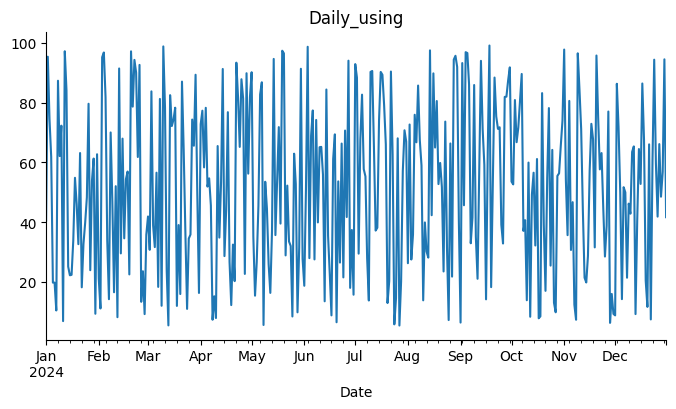

In [ ]:
# @title Daily_using

from matplotlib import pyplot as plt
storage['Daily_using'].plot(kind='line', figsize=(8, 4), title='Daily_using')
plt.gca().spines[['top', 'right']].set_visible(False)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.2496 - val_loss: 0.0241
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0397 - val_loss: 0.0125
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0384 - val_loss: 0.0125
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0362 - val_loss: 0.0147
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0349 - val_loss: 0.0186
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0360 - val_loss: 0.0229
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0331 - val_loss: 0.0160
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0339 - val_loss: 0.0153
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0291 - val_loss: 0.0197
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0371 - val_loss: 0.0164
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0293 - val_loss: 0.0122
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.

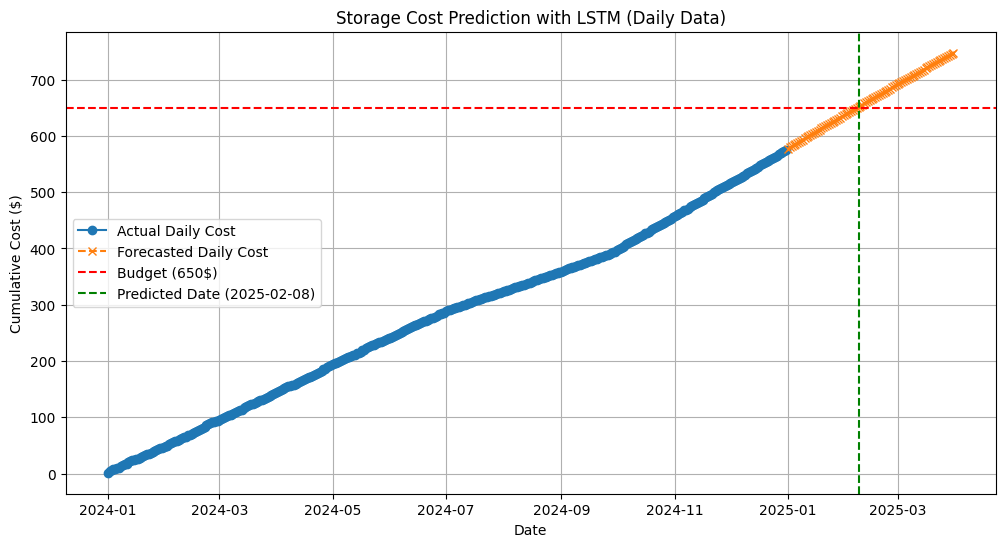

In [ ]:
# 굳 - test-val-pred dataset
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 생성 및 초기 설정
np.random.seed(42)
storage_cost = 0.025
budget = 650  # 목표 예산
forecast_steps = 90  # 예측할 최대 일 수

year = 2024
start_date = f"{year}-01-01"
end_date = f"{year}-12-31"
dates = pd.date_range(start=start_date, end=end_date)

# 하루당 증가 용량 (GB)
daily_using_1 = np.random.uniform(30, 100, size=len(dates)//2)
daily_using_2 = np.random.uniform(30, 60, size=len(dates)//4)
daily_using_3 = np.random.uniform(60, 100, size=len(dates) - len(daily_using_1) - len(daily_using_2))

# 모든 값을 합쳐서 daily_using 생성
daily_using = np.concatenate([daily_using_1, daily_using_2, daily_using_3])

storage = pd.DataFrame({
    'Daily_using': daily_using
})

storage['Date'] = dates
storage['Daily_growth'] = storage['Daily_using'].cumsum()
storage['Daily_cost'] = storage['Daily_growth'] * storage_cost
storage.set_index('Date', inplace=True)

# 데이터 준비
data = pd.DataFrame({
    'TotalCost': storage['Daily_cost']
})

# 차분 데이터 생성
data['Diff'] = data['TotalCost'].diff().fillna(0)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Diff']])

# LSTM 입력 데이터 준비 함수
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# 데이터 나누기 함수
def split_dataset(dataset, train_size=0.7):
    train_len = int(len(dataset) * train_size)
    train_data, val_data = dataset[:train_len], dataset[train_len:]
    return train_data, val_data

# look_back 설정
look_back = 60

# 70:30으로 학습 데이터와 검증 데이터 분리
train_data, val_data = split_dataset(data_scaled)

X_train, y_train = create_lstm_dataset(train_data, look_back)
X_val, y_val = create_lstm_dataset(val_data, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # LSTM 입력 형식
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))  # LSTM 입력 형식

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # 출력 레이어

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, min_delta=1e-4, verbose=1)

# 모델 학습
model.fit(X, y, epochs=100, batch_size=16, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

# 예측 데이터 생성
X_forecast = data_scaled[-look_back:]  # 가장 최근 데이터를 가져옴
X_forecast = np.reshape(X_forecast, (1, look_back, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    next_step = model.predict(X_forecast, verbose=0)
    forecast_scaled.append(next_step[0, 0])
    X_forecast = np.append(X_forecast[:, 1:, :], next_step.reshape(1, 1, 1), axis=1)

# 차분 데이터 복원
forecast_diff = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_cumulative = [data['TotalCost'].iloc[-1]] + list(np.cumsum(forecast_diff) + data['TotalCost'].iloc[-1])

# 예산 도달 시점 계산
predicted_day = None
for i, cost in enumerate(forecast_cumulative[1:], start=1):
    if cost >= budget:
        predicted_day = i
        break

# 결과 출력
if predicted_day:
    predicted_date = data.index[-1] + pd.Timedelta(days=predicted_day)
    print(f"예산 {budget}$는 약 {predicted_day}일 후에 도달할 것으로 예측됩니다.")
    print(f"해당 날짜는 {predicted_date.strftime('%Y-%m-%d')}입니다.")
else:
    print(f"{forecast_steps}일 내에 예산 {budget}$에 도달하지 않을 것으로 예측됩니다.")


# 예측 정확도 계산
y_true = data['TotalCost'][-forecast_steps:]  # 실제값
y_pred = forecast_cumulative[1:len(y_true) + 1]  # 예측값
if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
else:
    print("예측 정확도를 계산할 충분한 데이터가 없습니다.")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalCost'], label='Actual Daily Cost', marker='o')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(future_dates, forecast_cumulative[1:], label='Forecasted Daily Cost', marker='x', linestyle='--')
plt.axhline(y=budget, color='r', linestyle='--', label=f'Budget ({budget}$)')
if predicted_day:
    plt.axvline(x=predicted_date, color='g', linestyle='--', label=f'Predicted Date ({predicted_date.strftime("%Y-%m-%d")})')
plt.xlabel('Date')
plt.ylabel('Cumulative Cost ($)')
plt.title('Storage Cost Prediction with LSTM (Daily Data)')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.1979
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0526
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0556
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0425
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0557
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0482
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0492
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0489
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0512
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0546
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0526
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0416
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0466
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0515
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - 

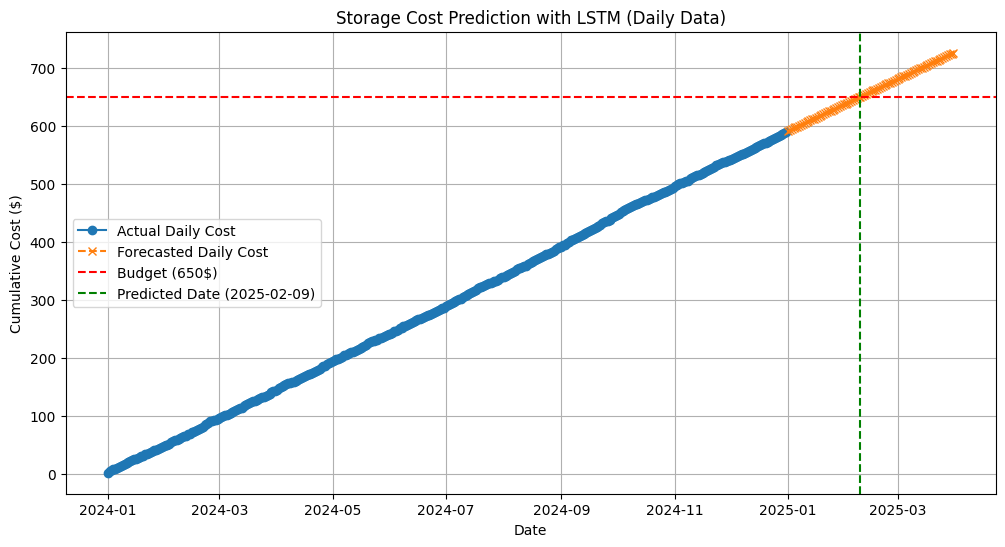

In [ ]:
# 굳
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 생성 및 초기 설정
np.random.seed(42)
storage_cost = 0.025
budget = 650  # 목표 예산
forecast_steps = 90  # 예측할 최대 일 수

# 하루당 증가 용량 (GB)
daily_using = np.random.uniform(30, 100, size=366)
storage = pd.DataFrame({
    'Daily_using': daily_using
})

storage['Date'] = pd.date_range(start="2024-01-01", end="2024-12-31")
storage['Daily_growth'] = storage['Daily_using'].cumsum()
storage['Daily_cost'] = storage['Daily_growth'] * storage_cost
storage.set_index('Date', inplace=True)

# 데이터 준비
data = pd.DataFrame({
    'TotalCost': storage['Daily_cost']
})

# 차분 데이터 생성
data['Diff'] = data['TotalCost'].diff().fillna(0)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Diff']])

# LSTM 입력 데이터 준비 함수
def create_lstm_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# look_back 설정
look_back = 60
X, y = create_lstm_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM 입력 형식

# LSTM 모델 구성
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # 출력 레이어

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, min_delta=1e-4, verbose=1)

# 모델 학습
model.fit(X, y, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])

# 예측 데이터 생성
X_forecast = data_scaled[-look_back:]  # 가장 최근 데이터를 가져옴
X_forecast = np.reshape(X_forecast, (1, look_back, 1))

forecast_scaled = []
for _ in range(forecast_steps):
    next_step = model.predict(X_forecast, verbose=0)
    forecast_scaled.append(next_step[0, 0])
    X_forecast = np.append(X_forecast[:, 1:, :], next_step.reshape(1, 1, 1), axis=1)

# 차분 데이터 복원
forecast_diff = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
forecast_cumulative = [data['TotalCost'].iloc[-1]] + list(np.cumsum(forecast_diff) + data['TotalCost'].iloc[-1])

# 예산 도달 시점 계산
predicted_day = None
for i, cost in enumerate(forecast_cumulative[1:], start=1):
    if cost >= budget:
        predicted_day = i
        break

# 결과 출력
if predicted_day:
    predicted_date = data.index[-1] + pd.Timedelta(days=predicted_day)
    print(f"예산 {budget}$는 약 {predicted_day}일 후에 도달할 것으로 예측됩니다.")
    print(f"해당 날짜는 {predicted_date.strftime('%Y-%m-%d')}입니다.")
else:
    print(f"{forecast_steps}일 내에 예산 {budget}$에 도달하지 않을 것으로 예측됩니다.")


# 예측 정확도 계산
y_true = data['TotalCost'][-forecast_steps:]  # 실제값
y_pred = forecast_cumulative[1:len(y_true) + 1]  # 예측값
if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
else:
    print("예측 정확도를 계산할 충분한 데이터가 없습니다.")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['TotalCost'], label='Actual Daily Cost', marker='o')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(future_dates, forecast_cumulative[1:], label='Forecasted Daily Cost', marker='x', linestyle='--')
plt.axhline(y=budget, color='r', linestyle='--', label=f'Budget ({budget}$)')
if predicted_day:
    plt.axvline(x=predicted_date, color='g', linestyle='--', label=f'Predicted Date ({predicted_date.strftime("%Y-%m-%d")})')
plt.xlabel('Date')
plt.ylabel('Cumulative Cost ($)')
plt.title('Storage Cost Prediction with LSTM (Daily Data)')
plt.legend()
plt.grid()
plt.show()
